# Table of Contents

1. [Assignment](#assignment)
2. [Read and Explore all Datasets](#read-and-explore-all-datasets)
3. [Data Engineering](#data-engineering)
   - [Calculate the Total Cost of Ride](#calculate-the-total-cost-of-ride)
   - [Create Features of the Rides](#create-features-of-the-rides)
   - [Create Features of the Drivers](#create-features-of-the-drivers)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
   - [Main Factors Affecting a Driver's Lifetime Value](#main-factors-affecting-a-drivers-lifetime-value)
   - [Average Projected Lifetime of a Driver](#average-projected-lifetime-of-a-driver)
   - [Do All Drivers Act Alike? - Clustering Exercise](#do-all-drivers-act-alike---clustering-exercise)
5. [Actionable Recommendations](#actionable-recommendations)
6. [Assignment](#assignment-1)

## Assignment

We would like to answer some questions after exploring and analyzing the data. The questions are as follows:

- Recommend a Driver's Lifetime Value (i.e., the value of a driver to Lyft over the entire projected lifetime of a driver).
- What are the main factors that affect a driver's lifetime value?
- What is the average projected lifetime of a driver? That is, once a driver is onboarded, how long do they typically continue driving with Lyft?
- Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver?
- What actionable recommendations are there for the business?

## Read and Explore all Datasets


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
df_drive=pd.read_csv('driver_ids.csv')

In [3]:
df_drive.shape

(937, 2)

In [4]:
print('unique_number_of_drivers: ', df_drive['driver_id'].nunique())
print('min_driver_onboard_date: ', df_drive['driver_onboard_date'].min())
print('max_driver_onboard_date: ', df_drive['driver_onboard_date'].max())

unique_number_of_drivers:  937
min_driver_onboard_date:  2016-03-28 00:00:00
max_driver_onboard_date:  2016-05-15 00:00:00


In [5]:
df_ride=pd.read_csv('ride_ids.csv')

In [6]:
df_ride

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100
...,...,...,...,...,...
193497,ffff51a71f2f185ec5e97d59dbcd7a78,fc717192b3512767269ff5a54b97af05,10127,1336,0
193498,ffff51a71f2f185ec5e97d59dbcd7a78,fd6fa5f9265d2cf83936ead663f9e0e7,1908,445,0
193499,ffff51a71f2f185ec5e97d59dbcd7a78,fe0857c43025264d337dfe1d8463e503,4039,875,0
193500,ffff51a71f2f185ec5e97d59dbcd7a78,ff0db0ca4557bf5b05b4da6f660a1ac1,4760,777,0


In [7]:
df_ride.describe()

,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


In [8]:
print('number_of_rides: ', df_ride['ride_id'].nunique())
print('number_of_drivers: ', df_ride['driver_id'].nunique())

number_of_rides:  193502
number_of_drivers:  937


In [9]:
df_timestamp = pd.read_csv('ride_timestamps.csv')
df_timestamp.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [10]:
print('event: ', df_timestamp['event'].unique())
print('number_of_rides: ', df_timestamp['ride_id'].nunique())

event:  ['requested_at' 'accepted_at' 'arrived_at' 'picked_up_at' 'dropped_off_at']
number_of_rides:  194081


## Data Engineering

## Calculate the Total Cost of Ride
We calculate the cost per ride using the assumptions from the Lyft rate card given:

- Base Fare: $2.00 

- Cost per Mile: $1.15

- Cost per Minute: $0.22

- Service Fee: $1.75

- Minimum Fare: $5.00

- Maximum Fare: $400.00

cost_per_ride= (base_fare + cost_per_mile × ride_distance + cost_per_minute × ride_duration)×(1+ride_prime_time/100) + service_fee


After that, we check if there are any costs less than minimum fare, or more than maximum fare are change them appropriately, to either minimum or maximum Fare respectively.

 


In [11]:
# calc. total life time of ride (convert ride_distance from meters to miles, convert ride_duration from seconds to minutes)

df_ride['cost_per_ride']=((2+df_ride['ride_distance']*0.000621371*1.15+df_ride['ride_duration']/60*0.22)*
                          (1+df_ride['ride_prime_time']/100))+1.75

In [12]:
# Apply lower bound to ride cost (Minimum Fare)

df_ride['cost_per_ride']=np.where(df_ride['cost_per_ride']<5, 5, df_ride['cost_per_ride'] )

In [13]:
# Apply upper bound to ride cost (Maximum Fare)

df_ride['cost_per_ride']=np.where(df_ride['cost_per_ride']>400, 400, df_ride['cost_per_ride'] )

In [14]:
df_ride

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,cost_per_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,8.489647
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,9.118740
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,8.192574
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,77.861301
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,17.666299
...,...,...,...,...,...,...
193497,ffff51a71f2f185ec5e97d59dbcd7a78,fc717192b3512767269ff5a54b97af05,10127,1336,0,15.885184
193498,ffff51a71f2f185ec5e97d59dbcd7a78,fd6fa5f9265d2cf83936ead663f9e0e7,1908,445,0,6.745079
193499,ffff51a71f2f185ec5e97d59dbcd7a78,fe0857c43025264d337dfe1d8463e503,4039,875,0,9.844508
193500,ffff51a71f2f185ec5e97d59dbcd7a78,ff0db0ca4557bf5b05b4da6f660a1ac1,4760,777,0,10.000385


In [15]:
df_timestamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970405 entries, 0 to 970404
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ride_id    970405 non-null  object
 1   event      970405 non-null  object
 2   timestamp  970404 non-null  object
dtypes: object(3)
memory usage: 22.2+ MB


In [16]:
df_timestamp['timestamp']= pd.to_datetime(df_timestamp['timestamp'])

In [17]:
df_timestamp = df_timestamp.pivot(values = 'timestamp', index=['ride_id'], columns = 'event').reset_index()


In [18]:
df_timestamp.head()

event,ride_id,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:40:47,2016-05-11 19:35:15,2016-05-11 19:29:36
4,0000d9b24d8ccdd991b76258e616fa01,2016-04-26 18:12:15,2016-04-26 18:16:52,2016-04-26 18:24:14,2016-04-26 18:16:55,2016-04-26 18:11:38


### Create Features of the Rides

In [19]:
df_timestamp['ride_accept_response_time']= df_timestamp['accepted_at']-df_timestamp['requested_at']

In [20]:
#time a driver takes to accept a ride once it is requested in minutes
df_timestamp['ride_accept_response_time']=df_timestamp['ride_accept_response_time'].dt.total_seconds()/60

In [21]:
df_timestamp['ride_accept_response_time'].max()

83.8

In [22]:
df_timestamp['ride_arrival_time']= df_timestamp['arrived_at']-df_timestamp['accepted_at']

In [23]:
#time a driver takes to reach the pickup location once a ride is accepted in minutes
df_timestamp['ride_arrival_time']=df_timestamp['ride_arrival_time'].dt.total_seconds()/60

In [24]:
df_timestamp['ride_time']= df_timestamp['dropped_off_at']-df_timestamp['picked_up_at']

In [25]:
#time a driver takes to reach the destination location once a passenger is picked up in minutes

df_timestamp['ride_time']=df_timestamp['ride_time'].dt.total_seconds()/60

In [26]:
df_timestamp['ride_wait_time']= df_timestamp['picked_up_at']-df_timestamp['arrived_at']

In [27]:
#time a driver waits for the rider once the driver reaches the pickup location in minutes
df_timestamp['ride_wait_time']=df_timestamp['ride_wait_time'].dt.total_seconds()/60

In [28]:
# divide ride distance to 3 categories (Short ride, medium ride, long ride) dependant on ride_distance column (KM)

conditions = [df_timestamp['ride_time'] <=df_timestamp['ride_time'].quantile(0.33),
    ((df_timestamp['ride_time'] > df_timestamp['ride_time'].quantile(0.33))& (df_timestamp['ride_time'] <=df_timestamp['ride_time'].quantile(0.66))),
    df_timestamp['ride_time'] >df_timestamp['ride_time'].quantile(0.66)]

choices = ['short','medium','long']

In [29]:
df_timestamp['ride_length'] = np.select(conditions, choices)


In [30]:
# divide ride time to 3 categories (Morning ride, evening ride, night ride) dependant on accepted_at column (time)

conditions = [((df_timestamp['picked_up_at'].dt.hour >=6)&(df_timestamp['picked_up_at'].dt.hour <15)),
              ((df_timestamp['picked_up_at'].dt.hour >=15)& (df_timestamp['picked_up_at'].dt.hour<21)),
              ((df_timestamp['picked_up_at'].dt.hour >=21)|(df_timestamp['picked_up_at'].dt.hour <6))]

choices = ['morning','evening','night']

In [31]:
df_timestamp['ride_time'] = np.select(conditions, choices)


In [32]:
df_timestamp.head()

event,ride_id,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,ride_accept_response_time,ride_arrival_time,ride_time,ride_wait_time,ride_length
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19,0.533333,4.666667,morning,0.033333,long
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21,0.066667,2.866667,night,0.016667,short
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09,0.083333,4.250000,evening,0.050000,short
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:40:47,2016-05-11 19:35:15,2016-05-11 19:29:36,0.116667,5.466667,evening,0.066667,short
4,0000d9b24d8ccdd991b76258e616fa01,2016-04-26 18:12:15,2016-04-26 18:16:52,2016-04-26 18:24:14,2016-04-26 18:16:55,2016-04-26 18:11:38,0.616667,4.616667,evening,0.050000,short


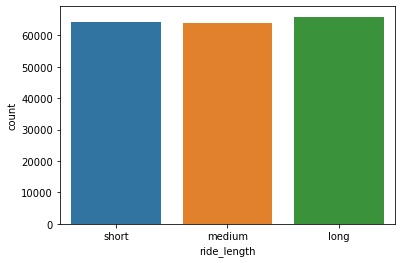

In [33]:
# count plot of ride length categories

sns.countplot(data=df_timestamp, x='ride_length', order=['short','medium','long']);

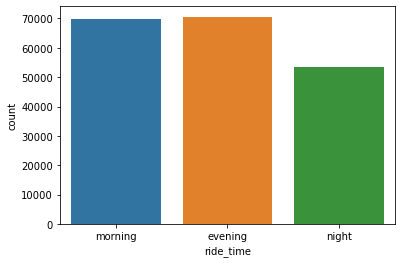

In [34]:
# count plot of ride time categories

sns.countplot(data=df_timestamp, x='ride_time', order=['morning','evening','night']);

In [35]:
#merge ride data and timestamp data
df_combined= pd.merge(df_ride, df_timestamp, on='ride_id')

In [36]:
df_combined['ride_date']=df_combined['picked_up_at'].dt.date

In [37]:
# calculate driver_perday_ridecount
driver_ride_count= df_combined.pivot_table( index='driver_id', columns='ride_date', aggfunc='size').fillna(0).reset_index()
driver_ride_count

ride_date,driver_id,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,...,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27
0,002be0ffdc997bd5c50703158b7c2491,0.0,6.0,0.0,8.0,7.0,5.0,0.0,0.0,7.0,...,3.0,0.0,2.0,9.0,3.0,5.0,0.0,0.0,0.0,0.0
1,007f0389f9c7b03ef97098422f902e62,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,011e5c5dfc5c2c92501b8b24d47509bc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0152a2f305e71d26cc964f8d4411add9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,12.0,10.0,4.0,7.0,3.0,0.0
4,01674381af7edd264113d4e6ed55ecda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,10.0,13.0,13.0,9.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,ff419a3476e21e269e340b5f1f05414e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,8.0,2.0,8.0,9.0,0.0
840,ff714a67ba8c6a108261cd81e3b77f3a,16.0,3.0,13.0,10.0,11.0,5.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
841,fff482c704d36a1afe8b8978d5486283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842,fffecccc49436c5389075b13209f0dfa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,10.0,3.0,3.0,4.0,5.0,2.0,17.0,11.0,0.0


In [38]:
 mean_ride_number= driver_ride_count.mean(axis=1)


In [39]:
# Calc. mean driver count ride per day

df_ride_number_per_day = pd.concat([driver_ride_count['driver_id'], mean_ride_number.reset_index()[0]], axis=1)
df_ride_number_per_day.columns=['driver_id', 'mean_ride_number_per_day']
df_ride_number_per_day

,driver_id,mean_ride_number_per_day
0,002be0ffdc997bd5c50703158b7c2491,3.010870
1,007f0389f9c7b03ef97098422f902e62,0.336957
2,011e5c5dfc5c2c92501b8b24d47509bc,0.369565
3,0152a2f305e71d26cc964f8d4411add9,2.076087
4,01674381af7edd264113d4e6ed55ecda,4.076087
...,...,...
839,ff419a3476e21e269e340b5f1f05414e,2.630435
840,ff714a67ba8c6a108261cd81e3b77f3a,5.271739
841,fff482c704d36a1afe8b8978d5486283,0.380435
842,fffecccc49436c5389075b13209f0dfa,4.413043


In [40]:
 
df_total = pd.merge(df_combined, df_ride_number_per_day, on='driver_id')

In [41]:
df_total.columns

Index(['driver_id', 'ride_id', 'ride_distance', 'ride_duration',
       'ride_prime_time', 'cost_per_ride', 'accepted_at', 'arrived_at',
       'dropped_off_at', 'picked_up_at', 'requested_at',
       'ride_accept_response_time', 'ride_arrival_time', 'ride_time',
       'ride_wait_time', 'ride_length', 'ride_date',
       'mean_ride_number_per_day'],
      dtype='object')

In [42]:
# Calc. driver total ride count, driver total ride distance, driver total ride duration,driver lifetime value 
# Calc mean driver count ride per day, mean of ride accept responce time for every driver, mean of ride arrival time for every driver
# Calc mean of ride wait time for every driver
df_agg = df_total.groupby(['driver_id']).agg({'ride_id':'count', 'ride_distance':'sum', 'ride_duration':'sum',
                                       'cost_per_ride':'sum', 'mean_ride_number_per_day':'mean', 'ride_accept_response_time':'mean',
                                    'ride_arrival_time':'mean','ride_wait_time':'mean', }).reset_index()

In [43]:
#count total no. of short/medium/long evening rides
df_ride_agg = pd.pivot_table(data= df_combined, index='driver_id', columns='ride_length', aggfunc='size').reset_index()
df_ride_agg

ride_length,driver_id,long,medium,short
0,002be0ffdc997bd5c50703158b7c2491,80.0,104.0,93.0
1,007f0389f9c7b03ef97098422f902e62,6.0,14.0,11.0
2,011e5c5dfc5c2c92501b8b24d47509bc,8.0,14.0,12.0
3,0152a2f305e71d26cc964f8d4411add9,73.0,62.0,56.0
4,01674381af7edd264113d4e6ed55ecda,172.0,112.0,91.0
...,...,...,...,...
839,ff419a3476e21e269e340b5f1f05414e,115.0,73.0,54.0
840,ff714a67ba8c6a108261cd81e3b77f3a,212.0,123.0,150.0
841,fff482c704d36a1afe8b8978d5486283,8.0,15.0,12.0
842,fffecccc49436c5389075b13209f0dfa,156.0,119.0,131.0


In [44]:
# count total no. of day/night/night evening rides

df_time_agg = pd.pivot_table(data= df_combined, index='driver_id', columns='ride_time', aggfunc='size').reset_index()
df_time_agg

ride_time,driver_id,evening,morning,night
0,002be0ffdc997bd5c50703158b7c2491,88.0,84.0,105.0
1,007f0389f9c7b03ef97098422f902e62,16.0,4.0,11.0
2,011e5c5dfc5c2c92501b8b24d47509bc,21.0,8.0,5.0
3,0152a2f305e71d26cc964f8d4411add9,18.0,69.0,104.0
4,01674381af7edd264113d4e6ed55ecda,NaN,375.0,NaN
...,...,...,...,...
839,ff419a3476e21e269e340b5f1f05414e,68.0,151.0,23.0
840,ff714a67ba8c6a108261cd81e3b77f3a,183.0,285.0,17.0
841,fff482c704d36a1afe8b8978d5486283,2.0,33.0,NaN
842,fffecccc49436c5389075b13209f0dfa,121.0,153.0,132.0


In [45]:
#merge all dataframes together to have aggregated data
df_test = pd.merge(df_agg, df_ride_agg, on=['driver_id'])
df_final= pd.merge(df_test, df_time_agg, on=['driver_id'])

In [46]:
df_final.columns=['driver_id', 'ride_numbers','total_ride_distance', 'total_ride_duration', 'total_value','mean_ride_number_per_day',
                 'mean_responce_acceptance_time', 'mean_arrival_time', 'mean_wait_time', 'long_ride_number', 'medium_ride_number',
                 'short_ride_number','evening_ride_number','morning_ride_number','night_ride_number']

In [47]:
df_final.head()

,driver_id,ride_numbers,total_ride_distance,total_ride_duration,total_value,mean_ride_number_per_day,mean_responce_acceptance_time,mean_arrival_time,mean_wait_time,long_ride_number,medium_ride_number,short_ride_number,evening_ride_number,morning_ride_number,night_ride_number
0,002be0ffdc997bd5c50703158b7c2491,277,1740287,221238,3560.922020,3.010870,0.140132,2.883153,0.087184,80.0,104.0,93.0,88.0,84.0,105.0
1,007f0389f9c7b03ef97098422f902e62,31,117531,20497,321.494667,0.336957,0.197312,2.952688,0.081183,6.0,14.0,11.0,16.0,4.0,11.0
2,011e5c5dfc5c2c92501b8b24d47509bc,34,269653,29205,482.427788,0.369565,0.121569,3.720588,0.068137,8.0,14.0,12.0,21.0,8.0,5.0
3,0152a2f305e71d26cc964f8d4411add9,191,1471239,174521,2610.868381,2.076087,0.236649,3.908813,0.091885,73.0,62.0,56.0,18.0,69.0,104.0
4,01674381af7edd264113d4e6ed55ecda,375,3123644,357443,5381.090771,4.076087,0.208800,3.608133,0.136800,172.0,112.0,91.0,NaN,375.0,NaN


In [48]:

onboard_data = df_combined.groupby(['driver_id']).agg({'ride_date':'max'}).reset_index()

In [49]:
# Calc how long do the driver typically continue driving with Lyft

df_drive_total = pd.merge( onboard_data, df_drive, on='driver_id')

df_drive_total['total_driving_days'] = (pd.to_datetime(df_drive_total['ride_date']) - pd.to_datetime(df_drive_total['driver_onboard_date'])).dt.days


In [50]:
df_drive_total

,driver_id,ride_date,driver_onboard_date,total_driving_days
0,002be0ffdc997bd5c50703158b7c2491,2016-06-23,2016-03-29 00:00:00,86
1,007f0389f9c7b03ef97098422f902e62,2016-06-22,2016-03-29 00:00:00,85
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-06-12,2016-04-05 00:00:00,68
3,0152a2f305e71d26cc964f8d4411add9,2016-06-26,2016-04-23 00:00:00,64
4,01674381af7edd264113d4e6ed55ecda,2016-06-24,2016-04-29 00:00:00,56
...,...,...,...,...
832,ff419a3476e21e269e340b5f1f05414e,2016-06-26,2016-04-26 00:00:00,61
833,ff714a67ba8c6a108261cd81e3b77f3a,2016-06-17,2016-03-28 00:00:00,81
834,fff482c704d36a1afe8b8978d5486283,2016-05-12,2016-04-08 00:00:00,34
835,fffecccc49436c5389075b13209f0dfa,2016-06-26,2016-05-06 00:00:00,51


In [51]:
driver_info= pd.merge(df_final, df_drive_total[['driver_id','total_driving_days']], on=['driver_id'])

In [52]:
driver_info

,driver_id,ride_numbers,total_ride_distance,total_ride_duration,total_value,mean_ride_number_per_day,mean_responce_acceptance_time,mean_arrival_time,mean_wait_time,long_ride_number,medium_ride_number,short_ride_number,evening_ride_number,morning_ride_number,night_ride_number,total_driving_days
0,002be0ffdc997bd5c50703158b7c2491,277,1740287,221238,3560.922020,3.010870,0.140132,2.883153,0.087184,80.0,104.0,93.0,88.0,84.0,105.0,86
1,007f0389f9c7b03ef97098422f902e62,31,117531,20497,321.494667,0.336957,0.197312,2.952688,0.081183,6.0,14.0,11.0,16.0,4.0,11.0,85
2,011e5c5dfc5c2c92501b8b24d47509bc,34,269653,29205,482.427788,0.369565,0.121569,3.720588,0.068137,8.0,14.0,12.0,21.0,8.0,5.0,68
3,0152a2f305e71d26cc964f8d4411add9,191,1471239,174521,2610.868381,2.076087,0.236649,3.908813,0.091885,73.0,62.0,56.0,18.0,69.0,104.0,64
4,01674381af7edd264113d4e6ed55ecda,375,3123644,357443,5381.090771,4.076087,0.208800,3.608133,0.136800,172.0,112.0,91.0,NaN,375.0,NaN,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,ff419a3476e21e269e340b5f1f05414e,242,2002400,246308,3538.373294,2.630435,0.218939,4.651997,0.114738,115.0,73.0,54.0,68.0,151.0,23.0,61
833,ff714a67ba8c6a108261cd81e3b77f3a,485,2834765,442492,6287.361980,5.271739,0.177663,2.976426,0.048144,212.0,123.0,150.0,183.0,285.0,17.0,81
834,fff482c704d36a1afe8b8978d5486283,35,174394,27693,380.661054,0.380435,0.303333,3.835238,0.034762,8.0,15.0,12.0,2.0,33.0,NaN,34
835,fffecccc49436c5389075b13209f0dfa,406,2924913,353974,6052.142374,4.413043,0.176929,3.572619,0.191051,156.0,119.0,131.0,121.0,153.0,132.0,51


## Exploratory Data Analysis

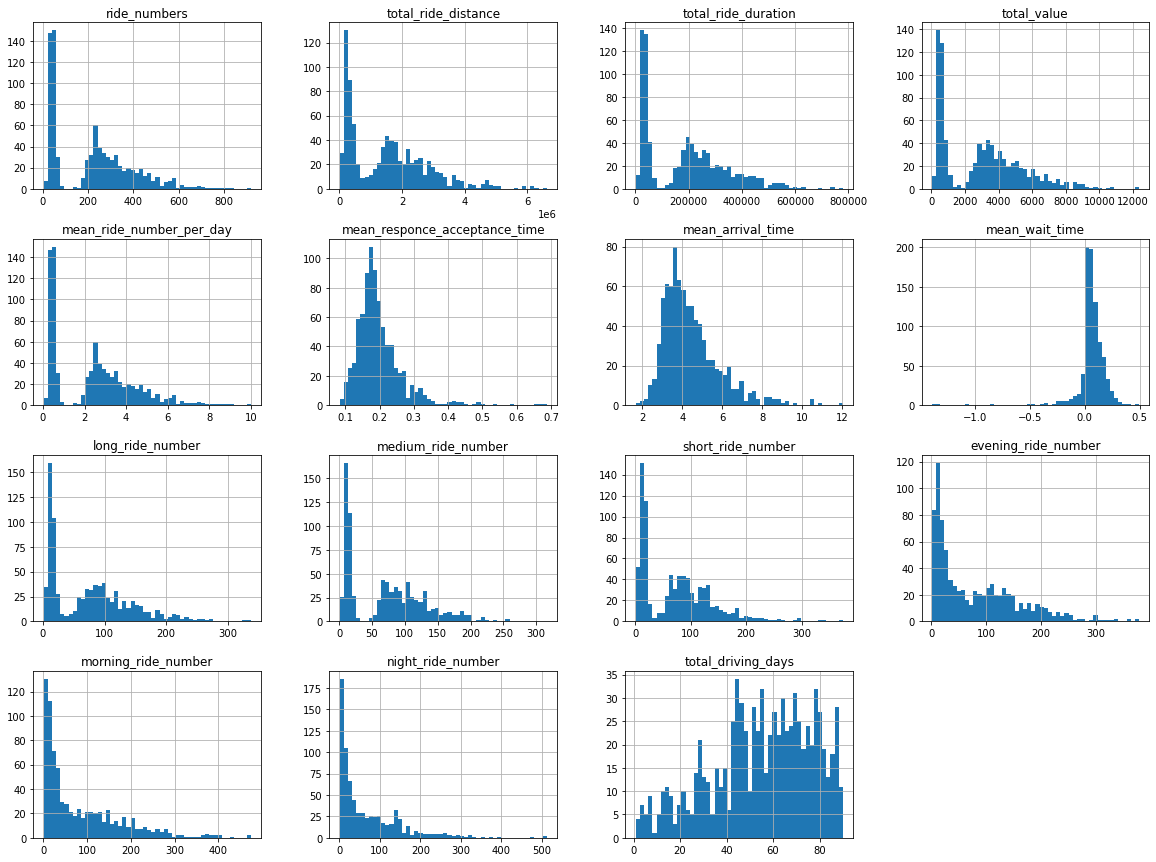

In [53]:
driver_info.hist(bins=50, figsize=(20,15));

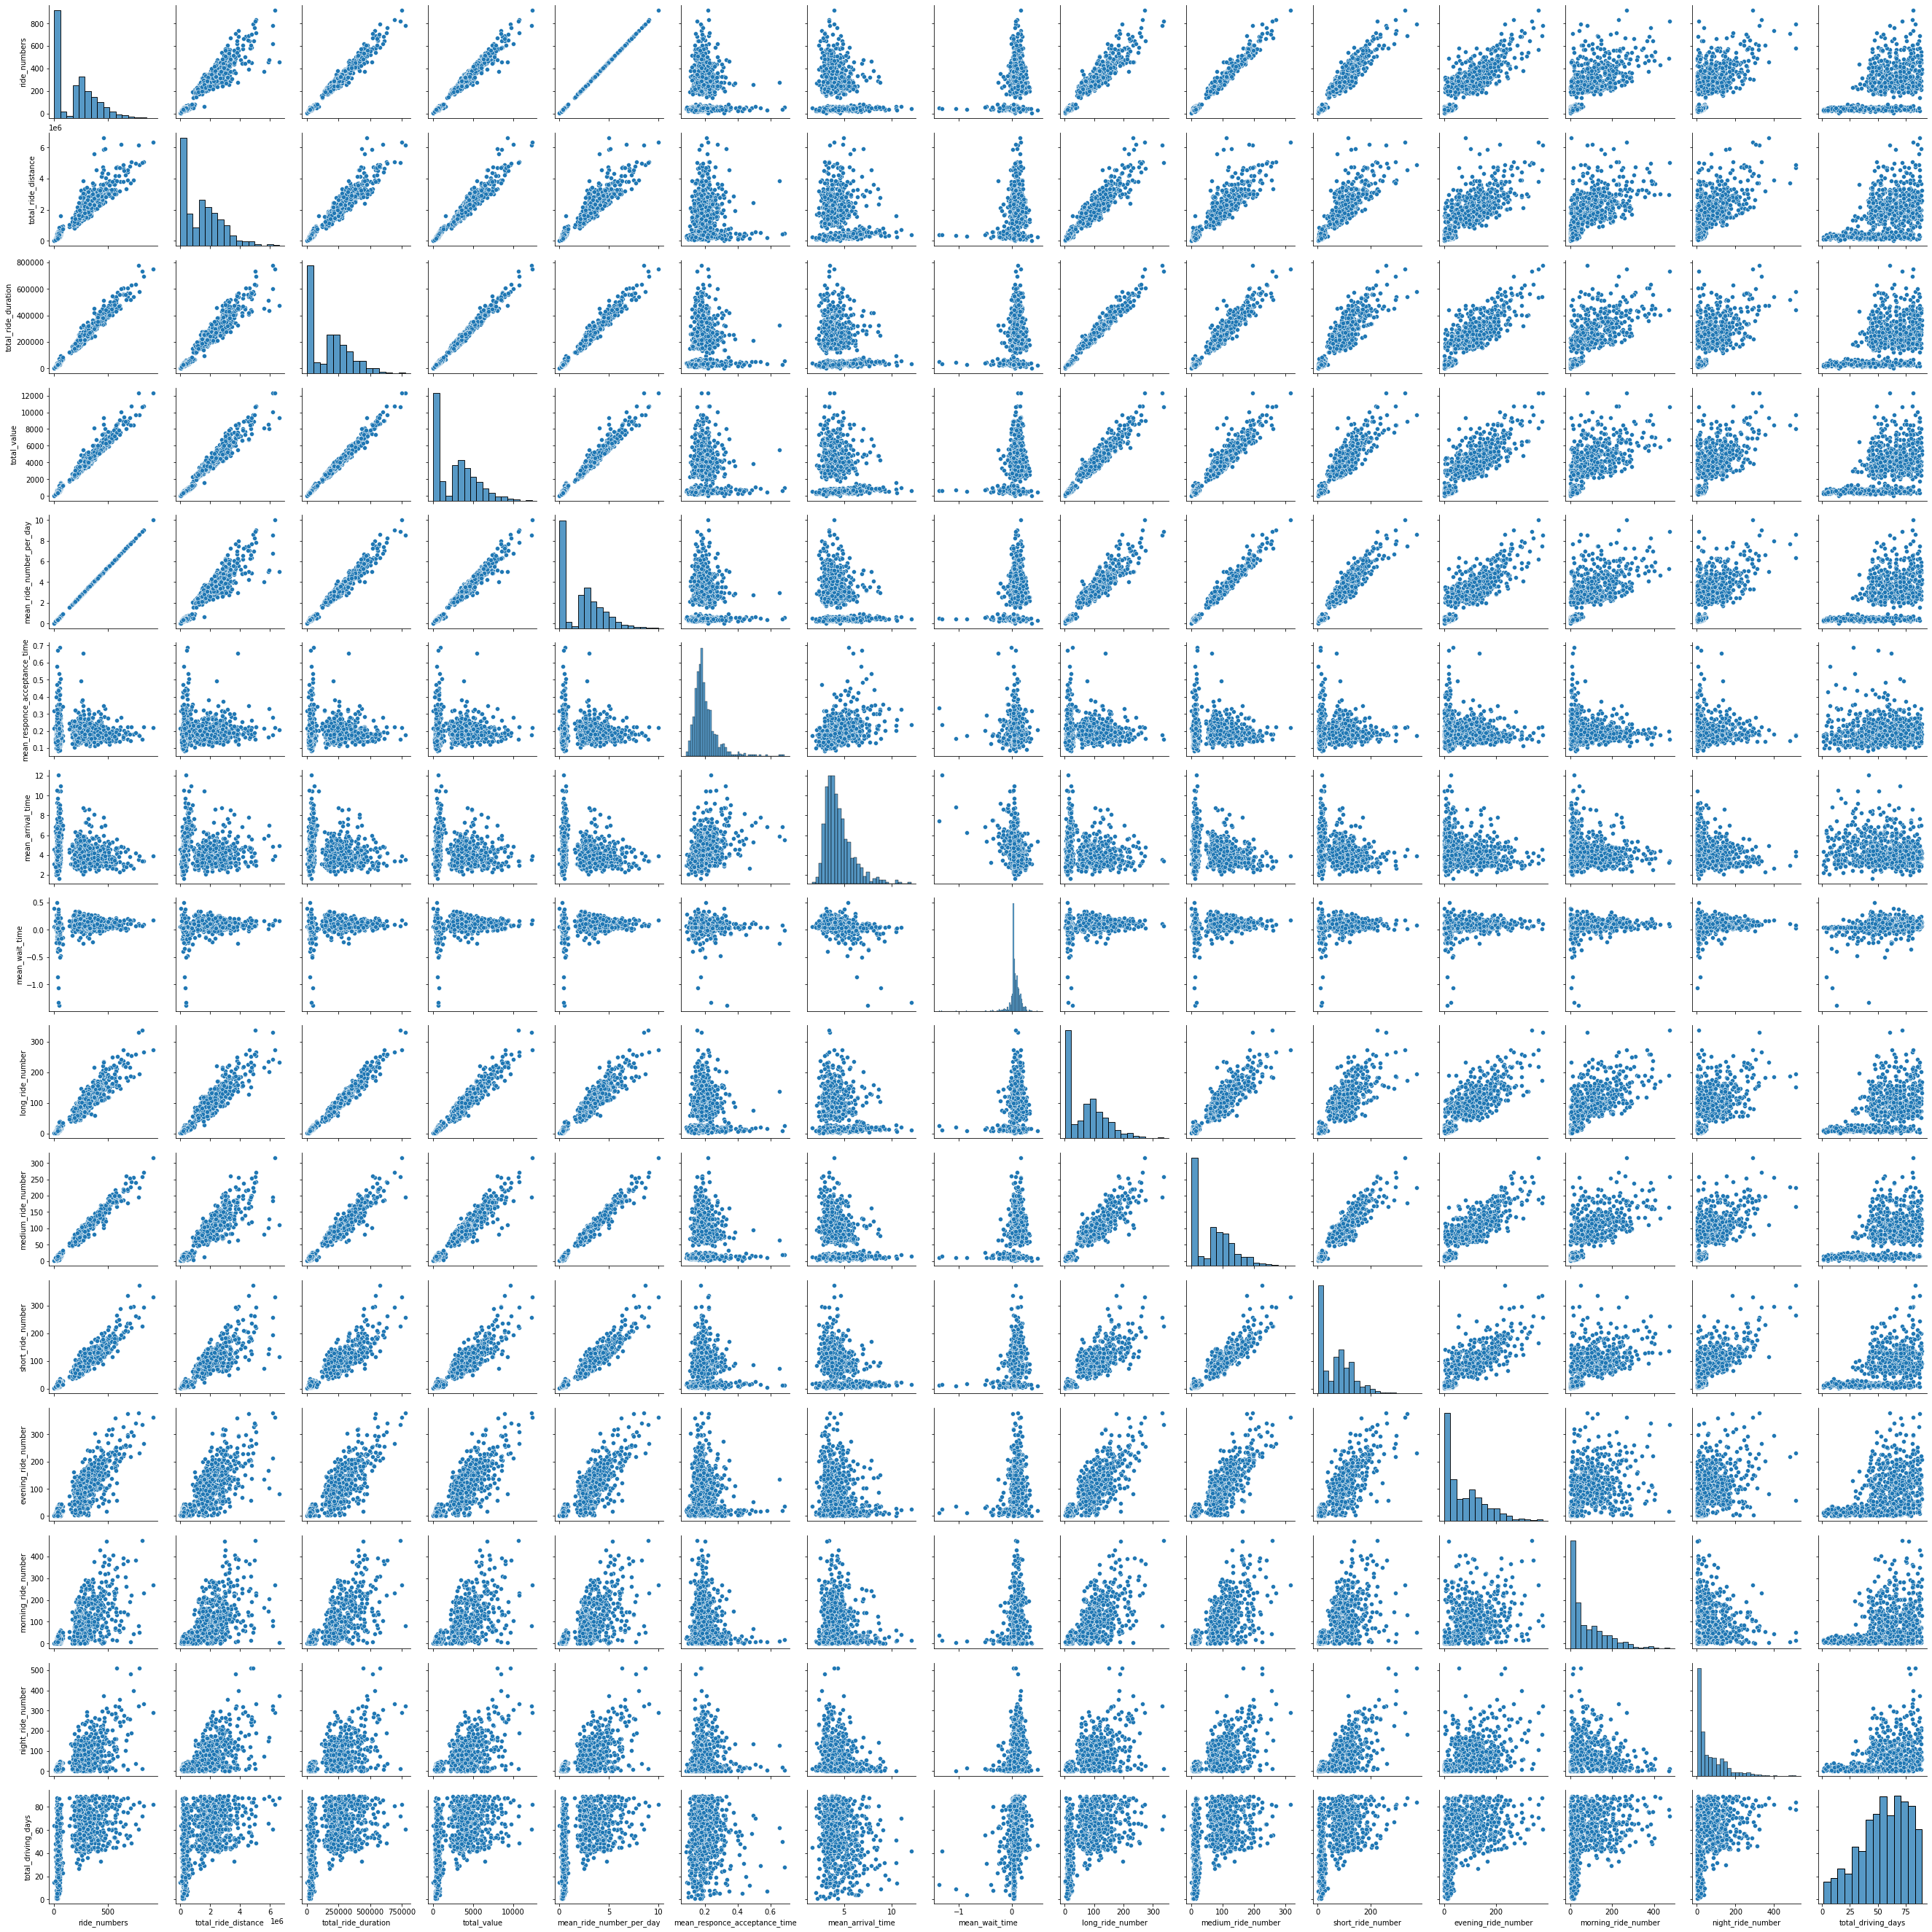

In [54]:
sns.pairplot(driver_info)

## Main Factors Affecting a Driver's Lifetime Value

<AxesSubplot:>

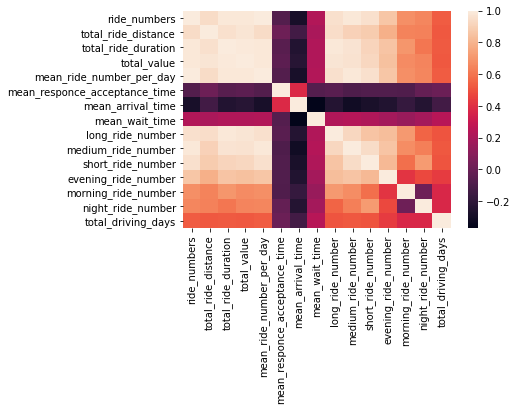

In [55]:
# plot a heatmap of correlations betweem features

sns.heatmap(driver_info.corr())

In [56]:
# get a correlation with lifetime_value as a DataFrame sorted in descending order

driver_info.corr()['total_value'].sort_values( ascending=False).iloc[1:]

total_ride_duration              0.994191
ride_numbers                     0.987063
mean_ride_number_per_day         0.987063
total_ride_distance              0.978461
long_ride_number                 0.976257
medium_ride_number               0.963166
short_ride_number                0.930375
evening_ride_number              0.846149
morning_ride_number              0.672578
night_ride_number                0.651351
total_driving_days               0.523614
mean_wait_time                   0.226384
mean_responce_acceptance_time   -0.040446
mean_arrival_time               -0.228536
Name: total_value, dtype: float64

## Average Projected Lifetime of a Driver

Text(0, 0.5, 'Number of Drivers')

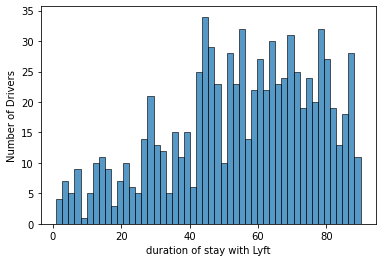

In [57]:

sns.histplot(driver_info['total_driving_days'], bins=50)
plt.xlabel('duration of stay with Lyft')
plt.ylabel('Number of Drivers')

In [58]:
driver_info['total_driving_days'].describe()

count    837.000000
mean      55.080048
std       21.725000
min        1.000000
25%       42.000000
50%       57.000000
75%       73.000000
max       90.000000
Name: total_driving_days, dtype: float64

After seeing these results we can say the average projected lifetime of a driver is around 55 days.



In [59]:
df_feature = driver_info.iloc[:,1:]

In [60]:
df_feature.describe()

,ride_numbers,total_ride_distance,total_ride_duration,total_value,mean_ride_number_per_day,mean_responce_acceptance_time,mean_arrival_time,mean_wait_time,long_ride_number,medium_ride_number,short_ride_number,evening_ride_number,morning_ride_number,night_ride_number,total_driving_days
count,837.000000,8.370000e+02,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,836.000000,837.000000,837.000000,827.000000,782.000000,747.000000,837.000000
mean,220.082437,1.528516e+06,189242.789725,2979.856090,2.392200,0.198516,4.417544,0.064720,74.964115,72.560335,72.647551,80.788392,84.584399,68.610442,55.080048
std,178.180347,1.259931e+06,154009.144305,2416.910266,1.936743,0.069286,1.406403,0.127561,62.929282,59.458946,61.430466,76.503462,89.822160,78.583212,21.725000
min,3.000000,9.895000e+03,1712.000000,25.691305,0.032609,0.084074,1.668056,-1.387415,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,44.000000,3.390140e+05,38363.000000,618.242984,0.478261,0.158730,3.458333,0.034524,15.000000,14.000000,16.000000,17.000000,16.000000,12.000000,42.000000
50%,224.000000,1.451389e+06,189906.000000,2959.137942,2.434783,0.184409,4.104848,0.059024,71.000000,71.000000,68.000000,52.000000,47.000000,34.000000,57.000000
75%,330.000000,2.311846e+06,288097.000000,4476.529318,3.586957,0.221540,5.042160,0.115833,116.000000,112.000000,113.000000,129.000000,132.250000,104.500000,73.000000
max,919.000000,6.628201e+06,779797.000000,12350.273237,9.989130,0.687500,12.045238,0.491954,337.000000,316.000000,374.000000,379.000000,474.000000,512.000000,90.000000


## Do All Drivers Act Alike? - Clustering Exercise

In [61]:
df_feature.fillna(0, inplace=True)


In [62]:
wcss = []
for n_clusters in range(1,10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_feature)
    wcss.append(kmeans.inertia_)

In [63]:
cluster_range= [i for i in range(1,10)]

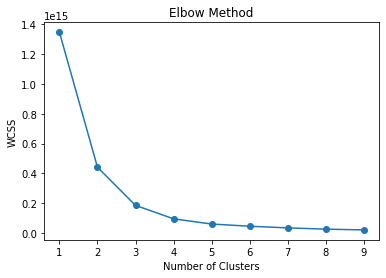

In [64]:
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [65]:
# Fit a K-Means model with the optimal number of clusters

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(df_feature)
cluster_labels = kmeans.labels_
# Add the cluster labels to the dataframe

df_feature['Cluster'] = cluster_labels


In [66]:
df_cluster = pd.concat( [driver_info[['driver_id']], df_feature], axis=1)
df_cluster

,driver_id,ride_numbers,total_ride_distance,total_ride_duration,total_value,mean_ride_number_per_day,mean_responce_acceptance_time,mean_arrival_time,mean_wait_time,long_ride_number,medium_ride_number,short_ride_number,evening_ride_number,morning_ride_number,night_ride_number,total_driving_days,Cluster
0,002be0ffdc997bd5c50703158b7c2491,277,1740287,221238,3560.922020,3.010870,0.140132,2.883153,0.087184,80.0,104.0,93.0,88.0,84.0,105.0,86,0
1,007f0389f9c7b03ef97098422f902e62,31,117531,20497,321.494667,0.336957,0.197312,2.952688,0.081183,6.0,14.0,11.0,16.0,4.0,11.0,85,1
2,011e5c5dfc5c2c92501b8b24d47509bc,34,269653,29205,482.427788,0.369565,0.121569,3.720588,0.068137,8.0,14.0,12.0,21.0,8.0,5.0,68,1
3,0152a2f305e71d26cc964f8d4411add9,191,1471239,174521,2610.868381,2.076087,0.236649,3.908813,0.091885,73.0,62.0,56.0,18.0,69.0,104.0,64,0
4,01674381af7edd264113d4e6ed55ecda,375,3123644,357443,5381.090771,4.076087,0.208800,3.608133,0.136800,172.0,112.0,91.0,0.0,375.0,0.0,56,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,ff419a3476e21e269e340b5f1f05414e,242,2002400,246308,3538.373294,2.630435,0.218939,4.651997,0.114738,115.0,73.0,54.0,68.0,151.0,23.0,61,0
833,ff714a67ba8c6a108261cd81e3b77f3a,485,2834765,442492,6287.361980,5.271739,0.177663,2.976426,0.048144,212.0,123.0,150.0,183.0,285.0,17.0,81,2
834,fff482c704d36a1afe8b8978d5486283,35,174394,27693,380.661054,0.380435,0.303333,3.835238,0.034762,8.0,15.0,12.0,2.0,33.0,0.0,34,1
835,fffecccc49436c5389075b13209f0dfa,406,2924913,353974,6052.142374,4.413043,0.176929,3.572619,0.191051,156.0,119.0,131.0,121.0,153.0,132.0,51,2


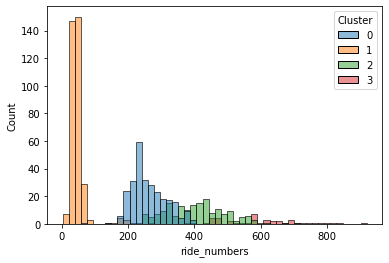

In [67]:
# Plot the distribution of total ride count by cluster

sns.histplot(data=df_cluster, x="ride_numbers", hue="Cluster", bins=50, palette="tab10");


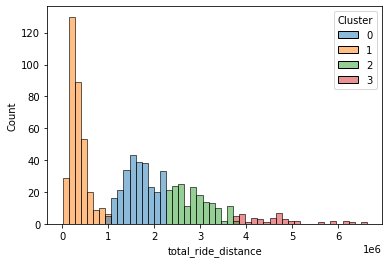

In [68]:
# Plot the distribution of total distance by cluster

sns.histplot(data=df_cluster, x="total_ride_distance", hue="Cluster", bins=50, palette="tab10");


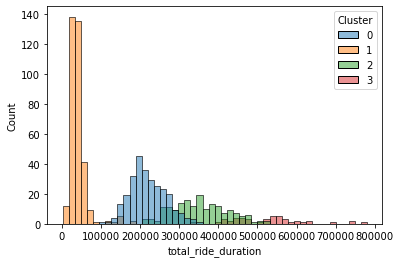

In [69]:
# Plot the distribution of total duration by cluster

sns.histplot(data=df_cluster, x="total_ride_duration", hue="Cluster", bins=50, palette="tab10");


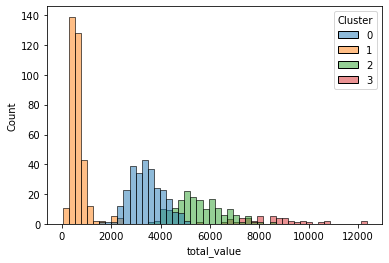

In [70]:
# Plot the distribution of total earnings by cluster

sns.histplot(data=df_cluster, x="total_value", hue="Cluster", bins=50, palette="tab10");


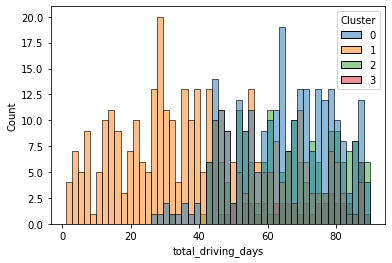

In [71]:
# Plot the distribution of driver's lifetime by cluster

sns.histplot(data=df_cluster, x="total_driving_days", hue="Cluster", bins=50, palette="tab10");


In [72]:
df_cluster.columns

Index(['driver_id', 'ride_numbers', 'total_ride_distance',
       'total_ride_duration', 'total_value', 'mean_ride_number_per_day',
       'mean_responce_acceptance_time', 'mean_arrival_time', 'mean_wait_time',
       'long_ride_number', 'medium_ride_number', 'short_ride_number',
       'evening_ride_number', 'morning_ride_number', 'night_ride_number',
       'total_driving_days', 'Cluster'],
      dtype='object')

In [73]:
df_mean_cluster =df_cluster.groupby(['Cluster'])['ride_numbers', 'total_ride_distance',
       'total_ride_duration', 'total_value', 'mean_ride_number_per_day',
       'mean_responce_acceptance_time', 'mean_arrival_time', 'mean_wait_time',
       'long_ride_number', 'medium_ride_number', 'short_ride_number',
       'evening_ride_number', 'morning_ride_number', 'night_ride_number',
       'total_driving_days'].mean().reset_index()

<ipython-input-73-c67e80f7df13>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_cluster =df_cluster.groupby(['Cluster'])['ride_numbers', 'total_ride_distance',


In [74]:
df_mean_cluster

,Cluster,ride_numbers,total_ride_distance,total_ride_duration,total_value,mean_ride_number_per_day,mean_responce_acceptance_time,mean_arrival_time,mean_wait_time,long_ride_number,medium_ride_number,short_ride_number,evening_ride_number,morning_ride_number,night_ride_number,total_driving_days
0,0,261.029412,1.670689e+06,219155.691176,3414.704716,2.837276,0.188861,3.951268,0.090866,85.301471,87.613971,88.113971,94.242647,94.801471,71.985294,64.397059
1,1,45.586705,3.443101e+05,39182.031792,628.161544,0.495508,0.203287,4.887029,0.024907,15.257225,14.789017,15.540462,17.930636,15.184971,12.471098,40.167630
2,2,406.517241,2.855192e+06,353228.948276,5547.013638,4.418666,0.201307,4.221181,0.095569,141.362069,134.775862,130.379310,143.609195,153.517241,109.390805,66.103448
3,3,593.377778,4.644568e+06,528156.600000,8507.013278,6.449758,0.209394,4.385363,0.093517,213.155556,185.200000,195.022222,221.911111,186.511111,184.955556,70.800000


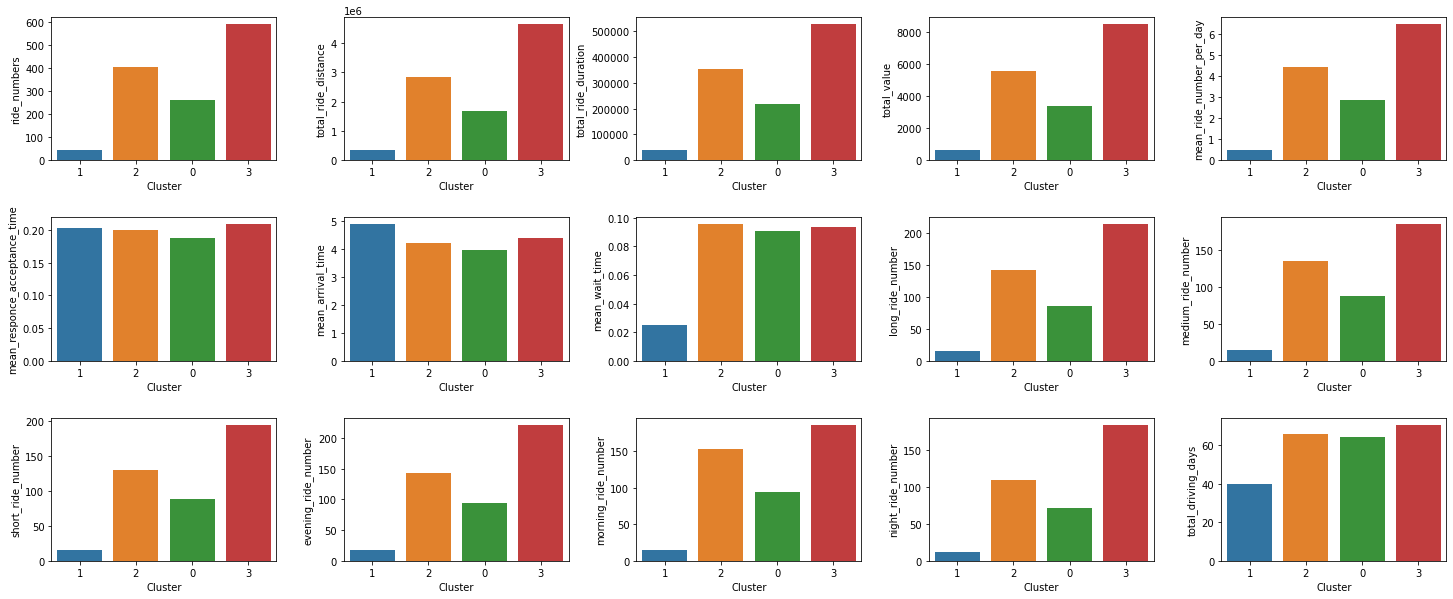

In [75]:
# create subplots for each column in the grouped dataframe

n_cols = 5
n_rows = -(-len(df_mean_cluster.columns) // n_cols)

fig, axes = plt.subplots(3, 5, figsize=(25, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

axes = axes.flatten()
for i, col in enumerate(df_mean_cluster.columns[1:]):
    sns.barplot(data=df_mean_cluster, x='Cluster', y=df_mean_cluster[col], ax=axes[i], order=[1,2,0,3])


## Clustering Analysis Results

After seeing these plots, we can define clusters as follows:

- **Cluster 2: Bad drivers**: This cluster has drivers with relatively low total lifetime value, low total ride count, and low total duration and distance. They may have issues with customer service, low demand for their services, or low fares.

- **Cluster 0: Fair drivers**: This cluster has drivers with moderate total lifetime value, ride count, duration, and distance. They may not have high demand for their services, but they also do not have any major issues that impact their earnings.

- **Cluster 3: Good drivers**: This cluster has drivers with higher total lifetime value, higher ride count, and higher total duration and distance compared to the first two clusters. They may have a consistent demand for their services and a good reputation, leading to higher earnings.

- **Cluster 1: Excellent drivers**: This cluster has drivers with the highest total lifetime value, ride count, and total duration and distance. These drivers are likely the most in demand and have a good reputation for providing excellent service to their customers, leading to high earnings.

## Actionable Recommendations

Here are a few actionable recommendations based on the clustering analysis performed on the driver information data:

1. **Focus on retaining good and excellent drivers**: The business should focus on retaining the drivers who belong to the good and excellent clusters as they bring in more revenue and have more frequent rides compared to other drivers.

2. **Target improvement of fair drivers**: The business should target to improve the performance of fair drivers, to convert them into good or excellent drivers.

3. **Identify and address issues faced by bad drivers**: The business should identify and address the issues faced by the bad drivers, such as low earnings, low ride frequency, and low ride duration, to improve their performance.

4. **Personalized incentives and training**: The business can offer personalized incentives and training to drivers based on their performance clusters to further improve their performance.

5. **Use clustering results for dynamic pricing**: The clustering results can be used for dynamic pricing, where prices can be adjusted based on the supply and demand of drivers in a particular area.

6. **Monitor performance regularly**: The business should regularly monitor the performance of drivers and reassess them based on the clustering results to ensure that they are being properly targeted with the appropriate incentives and support.

Implementing these recommendations will help Lyft optimize driver engagement, enhance overall service quality, and increase driver satisfaction, ultimately leading to improved customer experiences and business growth.
